In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
!tar -xf '/content/drive/MyDrive/Uni/UTKFace.tar.gz' -C '/content'

In [4]:
path_dir = 'UTKFace'

In [5]:
print(len(os.listdir(path_dir)))

23708


In [6]:
# Cek penamaan image
print(os.listdir(path_dir)[:10])

['26_1_2_20170116163008149.jpg.chip.jpg', '40_0_3_20170119180356516.jpg.chip.jpg', '16_1_0_20170109214519974.jpg.chip.jpg', '29_1_1_20170116010545437.jpg.chip.jpg', '40_1_0_20170116211621237.jpg.chip.jpg', '62_1_3_20170119211556000.jpg.chip.jpg', '38_0_0_20170117130715035.jpg.chip.jpg', '16_0_0_20170110232450588.jpg.chip.jpg', '29_1_2_20170116161428854.jpg.chip.jpg', '46_0_0_20170113181514861.jpg.chip.jpg']


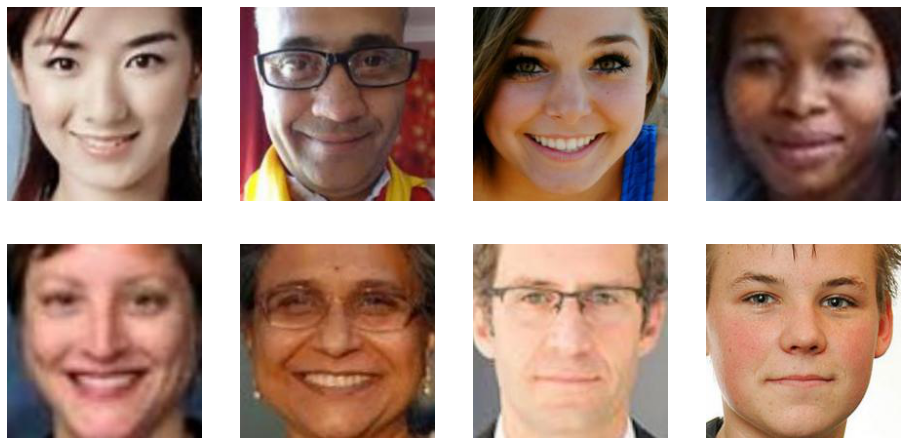

In [7]:
# Tampilkan contoh image
nrows = 2
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_img = [os.path.join(path_dir, fname) 
                for fname in os.listdir(path_dir)[0:8]]

for i, img_path in enumerate(next_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
pixels = []
gender = []
for f in os.listdir(path_dir):
  genders = f.split("_")[1]
  img = cv2.imread(str(path_dir)+"/"+str(f))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels.append(np.array(img))
  gender.append(np.array(genders))
pixels = np.array(pixels)
gender = np.array(gender,np.uint64)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(pixels, gender, test_size=0.15, random_state=100)

In [10]:
# Tampilkan jumlah data train dan test
print('total train images:', len(x_train))
print('total test images:', len(x_test))

total train images: 20151
total test images: 3557


In [11]:
# Tampilkan shape dari data train dan test
print("Train Data = ", x_train.shape)
print("Train Label = ", y_train.shape)
print("Test Data = ", x_test.shape)
print("Test Label = ", y_test.shape)

Train Data =  (20151, 200, 200, 3)
Train Label =  (20151,)
Test Data =  (3557, 200, 200, 3)
Test Label =  (3557,)


In [12]:
# Normalisasi dataset
# print("Before normalization:")
# print("Train: ", x_train[0][0][0])
# print("Test: ", x_test[0][0][0])

# scaler = preprocessing.MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

# print("After normalization:")
# print("Train: ", x_train[0][0][0])
# print("Test: ", x_test[0][0][0])

In [15]:
# Feature Extraction Layer
model = Sequential()
model.add(InputLayer(input_shape=(200,200,3)))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPool2D())
model.add(Dropout(0.25))
model.add(Flatten())
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                        

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [19]:
history = model.fit(x_train, y_train,
                    batch_size=64, 
                    epochs=20,
                    validation_split=0.15)

Epoch 1/20
268/268 [==============================] - 880s 3s/step - loss: 0.7942 - acc: 0.6024 - val_loss: 0.6398 - val_acc: 0.6222
Epoch 2/20
268/268 [==============================] - 987s 4s/step - loss: 0.6345 - acc: 0.6527 - val_loss: 0.5907 - val_acc: 0.6993
Epoch 3/20
268/268 [==============================] - 892s 3s/step - loss: 0.6227 - acc: 0.6622 - val_loss: 0.6084 - val_acc: 0.6795
Epoch 4/20
268/268 [==============================] - 877s 3s/step - loss: 0.5975 - acc: 0.6792 - val_loss: 0.5745 - val_acc: 0.7076
Epoch 5/20
268/268 [==============================] - 874s 3s/step - loss: 0.5831 - acc: 0.6945 - val_loss: 0.5337 - val_acc: 0.7321
Epoch 6/20
268/268 [==============================] - 869s 3s/step - loss: 0.5717 - acc: 0.7052 - val_loss: 0.5280 - val_acc: 0.7423
Epoch 7/20
268/268 [==============================] - 871s 3s/step - loss: 0.5623 - acc: 0.7150 - val_loss: 0.5232 - val_acc: 0.7407
Epoch 8/20
268/268 [==============================] - 844s 3s/step - 

In [20]:
model.save("gender-cnn-1.h5")

# from google.colab import files
# files.download("gender-cnn-1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
def eval_plot(epochs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

  ax1.plot(np.arange(0, epochs), history.history["acc"], label="train_acc")
  ax1.plot(np.arange(0, epochs), history.history["val_acc"], label="val_acc")
  ax1.set_title('Acc Result Plot')
  ax1.set(xlabel='Epoch #', ylabel='Acc')
  ax1.legend(loc="lower right")

  ax2.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
  ax2.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
  ax2.set_title('Loss Result Plot')
  ax2.set(xlabel='Epoch #', ylabel='Loss')
  ax2.legend(loc="upper right")
  plt.show()

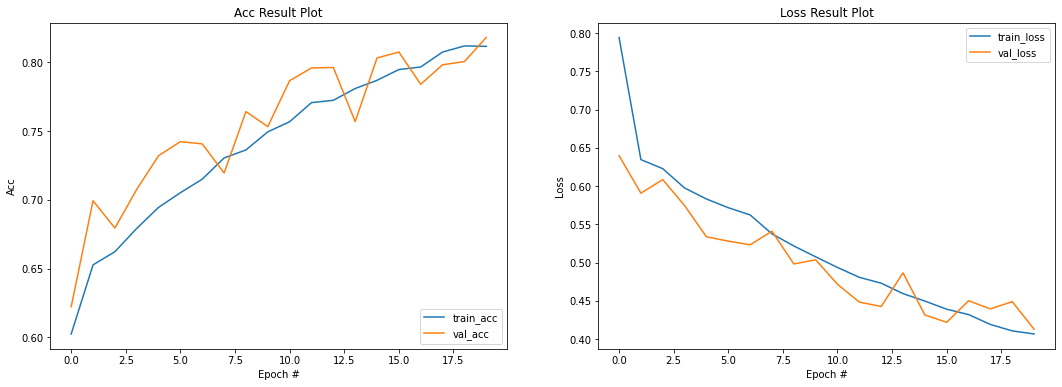

In [22]:
eval_plot(20)

In [23]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1866
           1       0.82      0.81      0.82      1691

    accuracy                           0.83      3557
   macro avg       0.83      0.83      0.83      3557
weighted avg       0.83      0.83      0.83      3557



In [27]:
def predictFunc(path):
  labels = ['male', 'female']
  img_upload = Image.open(path)

  img = np.array(img_upload)
  img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, model.layers[0].output_shape[1:3])
  img = img.astype('float32')/255  
  img = np.expand_dims(img, axis=0)
  # img = img.reshape(1, 150, 150, 1)
  pred = model.predict(img)[0]
  index_label = int(np.where(pred==max(pred))[0])

  label_pred = labels[index_label]
  pred_prob = str(pred[index_label])

  return label_pred, pred_prob

Predicted Label : male
Probability : 0.5713488


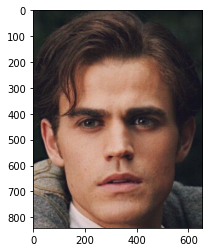

In [32]:
predict_path = '/content/drive/MyDrive/Uni/test-img-paul.jpg'
img_upload = Image.open(predict_path)

lbl, prob = predictFunc(predict_path)
print('Predicted Label :', lbl)
print('Probability :', prob)

img_plt = plt.imshow(img_upload)
plt.show()



---

